# DFL benchmark - training

In [1]:
!nvidia-smi

Thu Oct  6 08:08:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    39W / 350W |    637MiB / 24576MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# from IPython.display import Video
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

# Configuration

In [3]:
DEBUG = False
ALLDATA_USE = False

In [4]:
class CFG:
    TRAIN_CSV = "/workdir/work/output/3dcnn_train_images.csv"
    TRAIN_IMG_DIR = "/workdir/work/output/3dcnn_traindata"
    IMAGE_SIZE = 256
    NUM_IMAGES = 8
    INPUT_CHANNEL = 3
    BATCH_SIZE = 16
    
    if DEBUG:
        epoch_num = 3
    else:
        epoch_num = 100

## train valid data setting

In [5]:
err_tol = {
    'challenge': [ 0.30, 0.40, 0.50, 0.60, 0.70 ],
    'play': [ 0.15, 0.20, 0.25, 0.30, 0.35 ],
    'throwin': [ 0.15, 0.20, 0.25, 0.30, 0.35 ]
}

if DEBUG:
    video_id_split = {
        'val':['3c993bd2_0'],
        'train':['1606b0e6_0']
    }
else:
    video_id_split = {
        'val':['3c993bd2_0','3c993bd2_1'],
        'train':['1606b0e6_0','1606b0e6_1']
    }
    
#                  '35bd9041_0','35bd9041_1',
#                  '407c5a9e_1','4ffd5986_0','cfbe2e94_0','cfbe2e94_1',
#                  '9a97dae4_1','ecf251d4_0',]
    
    
if ALLDATA_USE:
    video_id_split = {
        'val':['3c993bd2_0','3c993bd2_1'],
        'train':['1606b0e6_0','1606b0e6_1','35bd9041_0','35bd9041_1',
                 '407c5a9e_1','4ffd5986_0','cfbe2e94_0','cfbe2e94_1',
                 '9a97dae4_1','ecf251d4_0']
    }

event_names = ['challenge', 'throwin', 'play']

# Read Image function

In [6]:
# def load_images_3d(file_names_str, num_imgs=CFG.NUM_IMAGES, img_size=CFG.IMAGE_SIZE):
#     img3d = []
#     files = file_names_str.split(",")
#     for file in files:
#         image = cv2.imread(file)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (img_size, img_size))
#         if len(img3d) > 0:
#             img3d = np.concatenate([img3d, np.expand_dims(image, 0)], axis=0)
#         else:
#             img3d = np.expand_dims(image, 0)
       
#     if img3d.shape[0] < num_imgs:
#         n_zero = np.zeros((num_imgs - img3d.shape[0], img_size, img_size, CFG.INPUT_CHANNEL))
#         img3d = np.concatenate((img3d,  n_zero), axis=0)
        
#     if np.min(img3d) < np.max(img3d):
#         img3d = img3d - np.min(img3d)
#         img3d = img3d / np.max(img3d)
            
#     return img3d

# Load Data

In [7]:
# train_valid_df = pd.read_csv(CFG.TRAIN_CSV)
# training_df = train_valid_df[train_valid_df["event"]=="background"].sample(10000)

# tmp = train_valid_df[train_valid_df["event"]=="play"].sample(10000)
# training_df = pd.concat([training_df, tmp])

# tmp = train_valid_df[train_valid_df["event"]=="challenge"].sample(10000)
# training_df = pd.concat([training_df, tmp])

# tmp = train_valid_df[train_valid_df["event"]=="throwin"]
# training_df = pd.concat([training_df, tmp])

# training_df = training_df.reset_index(drop=True)

# training_df.to_csv("/workdir/work/output/training_df_3dnn.csv", index=False)
# print(len(training_df))
# display(training_df.head())
# display(training_df["event"].value_counts())

train_valid_df = pd.read_csv(CFG.TRAIN_CSV)
training_df = train_valid_df[train_valid_df["event"]=="background"].sample(3000)

tmp = train_valid_df[train_valid_df["event"]=="play"].sample(3000)
training_df = pd.concat([training_df, tmp])

tmp = train_valid_df[train_valid_df["event"]=="challenge"].sample(3000)
training_df = pd.concat([training_df, tmp])

tmp = train_valid_df[train_valid_df["event"]=="throwin"].sample(3000)
training_df = pd.concat([training_df, tmp])

training_df = training_df.reset_index(drop=True)

training_df.to_csv("/workdir/work/output/training_df_3dnn.csv", index=False)
print(len(training_df))
display(training_df.head())
display(training_df["event"].value_counts())

12000


,video_id,frame,file_name,event
0,3c993bd2_1,38454,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
1,3c993bd2_1,41890,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
2,1606b0e6_0,63427,/workdir/work/output/3dcnn_traindata/1606b0e6_...,background
3,3c993bd2_0,21903,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
4,3c993bd2_1,68842,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background


background    3000
play          3000
challenge     3000
throwin       3000
Name: event, dtype: int64

In [8]:
df_train = training_df[training_df["video_id"].isin(video_id_split["train"])]
df_valid = training_df[training_df["video_id"].isin(video_id_split["val"])]

In [9]:
print(len(training_df), len(df_train), len(df_valid))

12000 6025 5975


## Load image check

In [10]:
training_df

,video_id,frame,file_name,event
0,3c993bd2_1,38454,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
1,3c993bd2_1,41890,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
2,1606b0e6_0,63427,/workdir/work/output/3dcnn_traindata/1606b0e6_...,background
3,3c993bd2_0,21903,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
4,3c993bd2_1,68842,/workdir/work/output/3dcnn_traindata/3c993bd2_...,background
...,...,...,...,...
11995,1606b0e6_1,60408,/workdir/work/output/3dcnn_traindata/1606b0e6_...,throwin
11996,3c993bd2_1,70876,/workdir/work/output/3dcnn_traindata/3c993bd2_...,throwin
11997,1606b0e6_0,24118,/workdir/work/output/3dcnn_traindata/1606b0e6_...,throwin
11998,3c993bd2_0,9819,/workdir/work/output/3dcnn_traindata/3c993bd2_...,throwin


In [11]:
# (channel, size, size, img_num, batchsize) 形式

# def load_images_3d(file_names_str_, num_imgs=CFG.NUM_IMAGES, img_size=CFG.IMAGE_SIZE):
#     img3d = []
#     files = file_names_str_.split(",")
#     for file in files:
#         image = cv2.imread(file)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, (img_size, img_size))
#         if len(img3d) > 0:
#             # これ転地でいいのか？w,hの方向は要確認
#             img3d = np.concatenate([img3d, np.expand_dims(image.T, -1)], axis=3)
#         else:
#             img3d = np.expand_dims(image.T, 3)

#     if img3d.shape[2] < num_imgs:
#         n_zero = np.zeros((CFG.INPUT_CHANNEL, img_size, img_size, num_imgs - img3d.shape[2]))
#         # n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[2],CFG.INPUT_CHANNEL))
#         # n_zero = np.zeros((num_imgs - img3d.shape[0], img_size, img_size, CFG.INPUT_CHANNEL))
#         img3d = np.concatenate((img3d,  n_zero), axis=3)
        
#     if np.min(img3d) < np.max(img3d):
#         img3d = img3d - np.min(img3d)
#         img3d = img3d / np.max(img3d)
            
#     return img3d

In [12]:
# (batchsize, width, height, depth, channel) 形式

def load_images_3d(file_names_str_, num_imgs=CFG.NUM_IMAGES, img_size=CFG.IMAGE_SIZE):
    img3d = []
    files = file_names_str_.split(",")
    for file in files:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_size, img_size))
        if len(img3d) > 0:
            # これ転地でいいのか？w,hの方向は要確認
            img3d = np.concatenate([img3d, np.expand_dims(image, 2)], axis=2)
        else:
            img3d = np.expand_dims(image, 2)

    if img3d.shape[2] < num_imgs:
        # n_zero = np.zeros((CFG.INPUT_CHANNEL, img_size, img_size, num_imgs - img3d.shape[2]))
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[2], CFG.INPUT_CHANNEL))
        # n_zero = np.zeros((num_imgs - img3d.shape[0], img_size, img_size, CFG.INPUT_CHANNEL))
        img3d = np.concatenate((img3d,  n_zero), axis=2)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return img3d

- データ形式はdataloader で呼び出したときに、(channel, size, size, img_num, batchsize)

input shape = (None, 256, 256, 8, 3)

(batchsize, width, height, depth, channel)

In [13]:
pick_df = train_valid_df[train_valid_df["frame"] >1000].sample(100)

filenames = pick_df["file_name"].values
# print(filenames)
files = filenames[0].split(",")
# print(files)
print(len(files))

8


(256, 256, 8, 3)
0.0 1.0 0.3899721856210745 0.37254901960784315
(256, 256, 3)


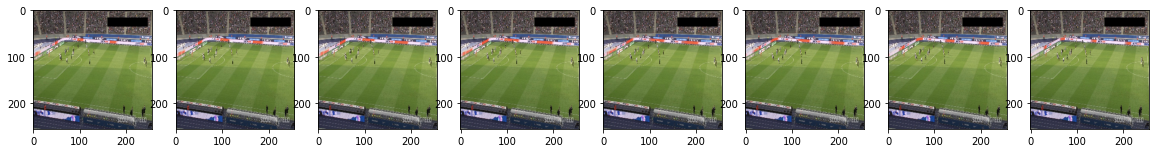

In [14]:
image3d = load_images_3d(filenames[0])
print(image3d.shape)
print(np.min(image3d), np.max(image3d), np.mean(image3d), np.median(image3d))

image = image3d[:,:,0]
print(image.shape)
fig, axes = plt.subplots(1, int(CFG.NUM_IMAGES), figsize=(20,10))
for i in range(image3d.shape[2]):
    # image = image3d[i]
    image = image3d[:,:,i]
    axes[i].imshow(image)
plt.show()

# Dataset

In [15]:
event_decoding = {
    0 : "background",
    1 : "challenge",
    2 : "play",
    3 : "throwin",
}

# event_encoding = {
#     "background" : 0,
#     "challenge" : 1,
#     "play" : 2,
#     "throwin" : 3,
# }
event_encoding = {
    "background" : [1,0,0,0],
    "challenge" : [0,1,0,0],
    "play" : [0,0,1,0],
    "throwin" : [0,0,0,1],
}

In [16]:
# from keras.utils import Sequence
from tensorflow.keras.utils import Sequence
import math
from random import shuffle

class Dataset(Sequence):
    def __init__(self, df, num_image=CFG.NUM_IMAGES,batch_size=CFG.BATCH_SIZE, shuffle=True):
        self.df = df
        self.idx = df.index.values
        self.video_id = df["video_id"].values
        self.frame = df["frame"].values
        self.file_name = df["file_name"].values
        self.event = df["event"].values
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __len__(self):
        return int(len(self.df)/self.batch_size)
   
    def __getitem__(self, idx):
        file_path = self.file_name[idx*self.batch_size : (idx+1)*self.batch_size]
        img_3d_list = [load_images_3d(file) for file in file_path]
        input_image_3d = np.stack(img_3d_list, axis=0)

        # labels = self.event[idx]
        label_event = self.event[idx*self.batch_size : (idx+1)*self.batch_size]
        targets = np.array([event_encoding[label] for label in label_event])
        # targets = np.array([]*input_image_3d.shape[2])
        # targets = np.array(event_encoding[labels])

        return input_image_3d, targets

    def on_epoch_end(self):
        if self.shuffle:
            ids_event = list(zip(self.idx, self.event))
            shuffle(ids_event)
            self.idx, self.y = list(zip(*ids_event))

## set dataset

In [17]:
train_dataset = Dataset(df_train, batch_size=CFG.BATCH_SIZE)
valid_dataset = Dataset(df_valid, batch_size=CFG.BATCH_SIZE)

## Check loader

In [18]:
print(len(df_train)/CFG.BATCH_SIZE)
print(len(train_dataset))

376.5625
376


input shape = (None, 256, 256, 8, 3)

(batchsize, width, height, depth, channel)

1
Dimension of the image is: (16, 256, 256, 8, 3)
label= (16, 4)


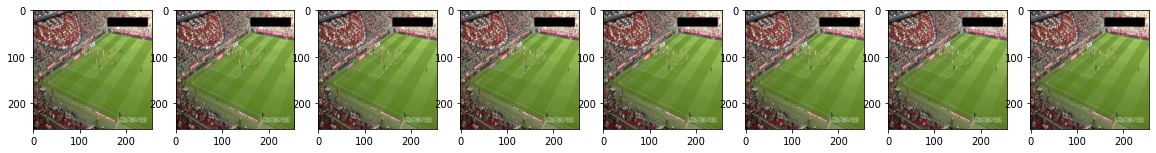

23
Dimension of the image is: (16, 256, 256, 8, 3)
label= (16, 4)


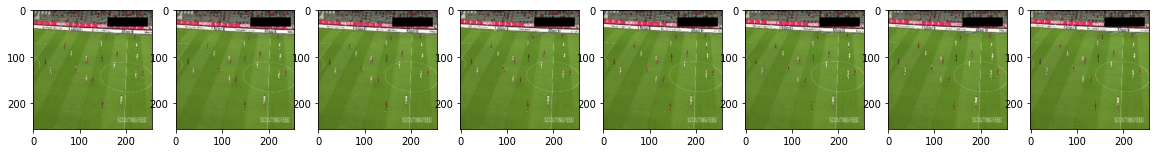

60
Dimension of the image is: (16, 256, 256, 8, 3)
label= (16, 4)


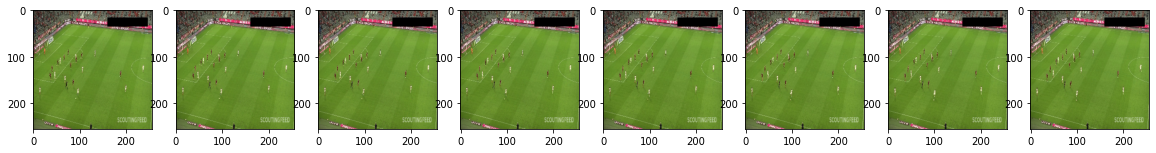

In [19]:
import random
for i in range(3):
    idx = random.randint(0,100)
    print(idx)
    images, label = train_dataset[idx]
    print("Dimension of the image is:", images.shape)
    print("label=",label.shape)
    fig, axes = plt.subplots(1, int(CFG.NUM_IMAGES), figsize=(20,10))
    for i in range(images.shape[3]):
        image = images[0,:,:,i,:]
        axes[i].imshow(image)
    plt.show()

# Model

In [20]:
# def get_model(width=CFG.IMAGE_SIZE, height=CFG.IMAGE_SIZE, depth=CFG.NUM_IMAGES, channel=CFG.INPUT_CHANNEL):
#     """Build a 3D convolutional neural network model."""

#     # inputs = keras.Input((width, height, depth, 1))
#     inputs = keras.Input((width, height, depth, channel))# rgb?

#     x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.01)(x)
    
#     x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.02)(x)

#     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.03)(x)

#     x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.04)(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=1024, activation="relu")(x)
#     x = layers.Dropout(0.08)(x)

#     outputs = layers.Dense(units=4, activation="sigmoid")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")

#     return model

In [21]:
# def get_model(width=CFG.IMAGE_SIZE, height=CFG.IMAGE_SIZE, depth=CFG.NUM_IMAGES, channel=CFG.INPUT_CHANNEL):
#     """Build a 3D convolutional neural network model."""

#     # inputs = keras.Input((width, height, depth, 1))
#     inputs = keras.Input((width, height, depth, channel))# rgb?

#     x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
#     x = layers.MaxPool3D()(x)
#     x = layers.BatchNormalization()(x)
    
#     # x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
#     # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
#     # x = layers.BatchNormalization()(x)
    
#     # x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu")(inputs)
#     # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(0.01)(x)
    
#     x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.02)(x)

#     # x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu")(x)
#     # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(0.03)(x)

#     # x = layers.Conv3D(filters=512, kernel_size=(3,3,3), activation="relu")(x)
#     # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
#     # x = layers.BatchNormalization()(x)
#     # x = layers.Dropout(0.04)(x)

#     x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Dense(units=1024, activation="relu")(x)
#     x = layers.Dropout(0.08)(x)

#     outputs = layers.Dense(units=4, activation="sigmoid")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")

#     return model

In [22]:
def get_model(width=CFG.IMAGE_SIZE, height=CFG.IMAGE_SIZE, depth=CFG.NUM_IMAGES, channel=CFG.INPUT_CHANNEL):
    """Build a 3D convolutional neural network model."""

    # inputs = keras.Input((width, height, depth, 1))
    inputs = keras.Input((width, height, depth, channel))# rgb?

    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=(2,2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=(3,3,3), activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=(2,2,2))(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=(2,2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    # x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu")(x)
    # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.02)(x)

    # x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu")(x)
    # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.03)(x)

    # x = layers.Conv3D(filters=512, kernel_size=(3,3,3), activation="relu")(x)
    # x = layers.MaxPool3D(pool_size=(2,2,2))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=4, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

In [23]:
# Build model.
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 8, 3)]  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 254, 254, 6, 64)   5248      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 127, 127, 3, 64)   0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 127, 127, 3, 64)   256       
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 3, 64)   0         
_________________________________________________________________
global_average_pooling3d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1024)              66560 

2022-10-06 08:08:47.012913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 08:08:47.023136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 08:08:47.023232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-06 08:08:47.023602: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [24]:
# Compile model.
initial_learning_rate = 1e-6
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
)
# Define callbacks.
model_save = ModelCheckpoint('3dcnn.h5', 
                             save_best_only = True, 
                             monitor = 'val_auc', 
                             mode = 'max', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_auc', 
                           patience = 10, mode = 'max', verbose = 1,
                           restore_best_weights = True)


In [25]:
# Train the model, doing validation at the end of each epoch
epochs = CFG.epoch_num
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = [model_save, early_stop],
)

2022-10-06 08:08:49.666811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-06 08:08:52.388385: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-10-06 08:08:52.938533: W tensorflow/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-06 08:08:52.938549: W tensorflow/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2022-10-06 08:08:52.938598: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-10-06 08:08:53.465024: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


376/376 [==============================] - 1461s 4s/step - loss: 0.6897 - auc: 0.4852 - acc: 0.2495 - val_loss: 0.6875 - val_auc: 0.4795 - val_acc: 0.2520

Epoch 00001: val_auc improved from -inf to 0.47948, saving model to 3dcnn.h5
Epoch 2/100
376/376 [==============================] - 1432s 4s/step - loss: 0.6867 - auc: 0.5078 - acc: 0.2645 - val_loss: 0.6787 - val_auc: 0.4833 - val_acc: 0.2659

Epoch 00002: val_auc improved from 0.47948 to 0.48333, saving model to 3dcnn.h5
Epoch 3/100
376/376 [==============================] - 1441s 4s/step - loss: 0.6837 - auc: 0.5283 - acc: 0.2964 - val_loss: 0.6727 - val_auc: 0.4895 - val_acc: 0.2659

Epoch 00003: val_auc improved from 0.48333 to 0.48949, saving model to 3dcnn.h5
Epoch 4/100
376/376 [==============================] - 1448s 4s/step - loss: 0.6806 - auc: 0.5389 - acc: 0.3256 - val_loss: 0.6671 - val_auc: 0.4936 - val_acc: 0.2659

Epoch 00004: val_auc improved from 0.48949 to 0.49361, saving model to 3dcnn.h5
Epoch 5/100
376/376 [==